In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from efficient_esm.models.esmfold import ESMFold

In [3]:
device = "cuda"
esm_path = "../data/esm2_t36_3B_UR50D.pt"
esmfold_path = "../data/esmfold_structure_module_only_3B.pt"

In [4]:
model = ESMFold.load(esmfold_path, esm_path).to(device)

In [5]:
seq = "ASAWPEEKNYHQPAILNSSALRQIAEGTSISEMWQNDLQPLLIERYPGSPGSYAARQHIMQRIQRLQADWVLEIDTFLSQTPYGYRSFSNIISTLNPTAKRHLVLACHYDSKYFSHWNNRVFVGATDSAVPCAMMLELARALDKKLLSLKTVSDSKPDLSLQLIFFDGEEAFLHWSPQDSLYGSRHLAAKMASTPHPPGARGTSQLHGMDLLVLLDLIGAPNPTFPNFFPNSARWFERLQAIEHELHELGLLKDHSLEGRYFQNYSYGGVIQDDHIPFLRRGVPVLHLIPSPFPEVWHTMDDNEENLDESTIDNLNKILQVFVLEYLHL"

In [6]:
# core quantization method (simulated quantization)
def pseudo_quantize_tensor(w, n_bit=4, q_group_size_candidates=[-1]):
    org_w_shape = w.shape

    found = False
    for q_group_size in q_group_size_candidates:
        if q_group_size <= 0:
            found = True
            break
        elif org_w_shape[-1] % q_group_size == 0:
            found = True
            break

    if not found:
        assert False, f"{org_w_shape[-1]} is not divisble by any q_group_size"
    
    if q_group_size > 0:
        assert org_w_shape[-1] % q_group_size == 0
        w = w.reshape(-1, q_group_size)

    assert w.dim() == 2

    # Calculate the maximum (\alpha) and minimum values (\beta) in the tensor.
    max_val = w.amax(dim=1, keepdim=True)
    assert max_val.dim() == 2 and max_val.size(0) == w.size(0) and max_val.size(1) == 1
    min_val = w.amin(dim=1, keepdim=True)
    assert min_val.dim() == 2 and min_val.size(0) == w.size(0) and min_val.size(1) == 1

    # Calculate the scale factor and zero point.  (Formula 1 & 2)
    max_int = 2 ** n_bit - 1
    scales = (max_val - min_val).clamp(min=1e-5) / max_int
    assert scales.shape == max_val.shape
    zeros = (-torch.round(min_val / scales)).clamp_(0, max_int)
    assert scales.shape == min_val.shape

    assert torch.isnan(scales).sum() == 0
    assert torch.isnan(w).sum() == 0

    # Quantize W: Map values in the range [\beta, \alpha] to lie within [0, 2^b - 1] (Formula 3)
    w = torch.clamp(torch.round(w / scales) + zeros, 0, max_int)
    assert w.dim() == 2 and w.size(0) == scales.size(0) and w.size(1) == q_group_size

    # Dequantize W (pseudo quantization, the inverse transformation of Formula 3)
    w = (w - zeros) * scales
    assert w.dim() == 2 and w.size(0) == scales.size(0) and w.size(1) == q_group_size

    assert torch.isnan(w).sum() == 0

    w = w.reshape(org_w_shape)
    return w

@torch.no_grad()
def pseudo_quantize_model_weight(
    model, w_bit, q_group_size_candidates,
):
    for n, m in model.named_modules():
        if isinstance(m, nn.Linear):
            m.weight.data = pseudo_quantize_tensor(m.weight.data, n_bit=w_bit, q_group_size_candidates=q_group_size_candidates)

In [7]:
# Only quantize the language model part (model.esm)
pseudo_quantize_model_weight(model.esm, w_bit=4, q_group_size_candidates=[128, 100, 144, 132])

In [8]:
model.eval()
with torch.no_grad():
    out = model.infer(seq)

In [9]:
p_ca = out["positions"][-1, 0, :, 1]
plddt = out["mean_plddt"].item()
print(f"{plddt:.2f}")

70.43


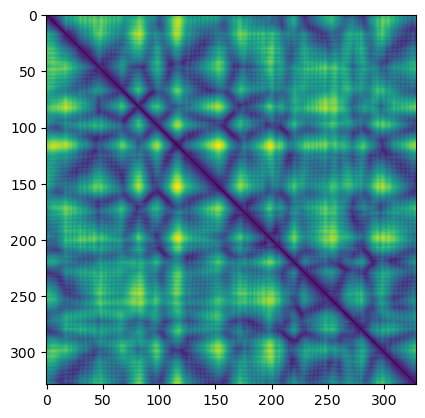

In [10]:
p_ca = out["positions"][-1, 0, :, 1]
dist = torch.cdist(p_ca, p_ca).cpu().numpy()
plt.imshow(dist)